<a href="https://colab.research.google.com/github/themendu/covid_from_ctscan/blob/master/corona_detector_from_ct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please visit my [**github**](https://github.com/themendu/covid_from_ctscan) for results and a better overview of my procedure and my basis of hypothesis.Please review my code and leave a comment.

In [0]:
pip install opencv-contrib-python-headless 

     |████████████████████████████████| 27.7MB 112kB/s 


Let us import the necessary packages.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torchvision
import cv2
from PIL import Image

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Since imshow function cannot be excecuted as a new window cannot be generated.

In [0]:
def cv2_imshow(a, **kwargs):
    a = a.clip(0, 255).astype('uint8')
    # cv2 stores colors as BGR; convert to RGB
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)

    return plt.imshow(a, **kwargs)


Now let us play with an image and let us removeall the noise in the image between the two lungs.Because we have to make sure our model,does not catch that.(If it catches a good accuracy will be obtaibed but it will not work on other images).

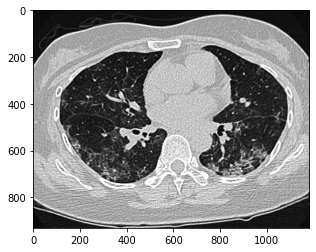

In [0]:
image = cv2.imread('/content/gdrive/My Drive/corona/xray_dataset/images/1-s2.0-S0929664620300449-gr3_lrg-c.jpg')
image1 = cv2.blur(image, (70,70))

cv2_imshow(image)

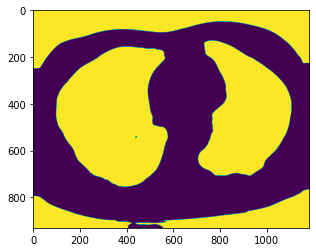

In [0]:
lower_black = np.array([0,0,0], dtype = "uint16")
upper_black = np.array([155,155,155], dtype = "uint16")
black_mask = cv2.inRange(image1, lower_black, upper_black)
cv2_imshow(black_mask)

I have tried with drawing contours in the image(commented line),but that did not help me as the boundary of the lung was not continuous.So,I have created a mask with retainig a certain color region values(tuned with trails) and performed bitwise and with the grey scale version of image and then turned the final image back to rgb.

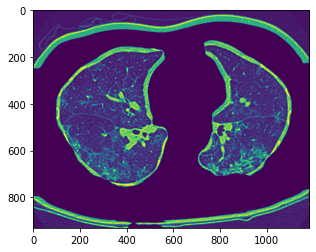

In [0]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
dest_and = cv2.bitwise_and(gray,black_mask, mask = None) 
(contours, _) = cv2.findContours(dest_and, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#image2=cv2.drawContours(image, contours, -1, (255, 0, 0), 3) 


cv2_imshow(dest_and)

Now I had to blur certain images and then apply median blurring so that my mask would be such that it retains the white patches at the lung boundary.This is where small amount of noise can be generated.

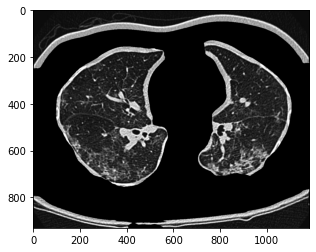

In [0]:
backtorgb = cv2.cvtColor(dest_and,cv2.COLOR_GRAY2RGB)
cv2_imshow(backtorgb)

So I applied different filters for each class(positive and negative images) and then modelled.Now while testing my model I would apply both filters make prediction on those two generated images and conclude by seeing result(would select maximum occurence).Now that need not be done here as obviously I know the output of those images.  

In [0]:
#mix all files and get training set

In [0]:
filenames_ct=pd.read_excel('/content/gdrive/My Drive/corona/ct_dataset/ct_scan/filenames_ct.xlsx')

In [0]:
i=0
covid_pos_names=[]
while i <350:
  covid_pos_names.append('/content/gdrive/My Drive/corona/ct_dataset/ct_scan/covidpos/'+filenames_ct.iloc[i,0])
  i=i+1

In [0]:
len(covid_pos_names)

350

In [0]:
i=352
covid_neg_names=[]
while i <746:
  covid_neg_names.append('/content/gdrive/My Drive/corona/ct_dataset/ct_scan/covidneg/'+filenames_ct.iloc[i,0])
  i=i+1

In [0]:
len(covid_neg_names)

394

Now I have tuned for the COVID-postive images to get better insights.

In [0]:
lower_black = np.array([0,0,0], dtype = "uint16")
upper_black = np.array([200,200,200], dtype = "uint16")

def image_converter1(path):
      image = cv2.imread(path)
      kernel = np.ones((5,5),np.float32)/25
      image3 = cv2.blur(image, (60,60))
      image_blurred= cv2.medianBlur(image3,3)
#      image_blurred = cv2.bilateralFilter(image2,40,100,100) 
#      image_blurred= cv2.filter2D(image2,-1,kernel)
      black_mask = cv2.inRange(image_blurred, lower_black, upper_black)
      gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      dest_and = cv2.bitwise_and(gray,black_mask, mask = None) 
      dest_and= cv2.cvtColor(dest_and,cv2.COLOR_GRAY2RGB)
      cv2.imwrite('/content/gdrive/My Drive/corona/ct_dataset/ct_scan/covidpos_changed/'+str(path[60:]),dest_and)
      return path[60:]



In [0]:
image_converter1(covid_pos_names[0])

'2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-89%0.png'

In [0]:
covid_pos_names.remove('/content/gdrive/My Drive/corona/ct_dataset/ct_scan/covidpos/0.jpg')

In [0]:
for name in covid_pos_names:
  print(name)
  image_converter1(name)

/content/gdrive/My Drive/corona/ct_dataset/ct_scan/covidpos/2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-89%0.png
/content/gdrive/My Drive/corona/ct_dataset/ct_scan/covidpos/2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-89%1.png
/content/gdrive/My Drive/corona/ct_dataset/ct_scan/covidpos/2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-91.png
/content/gdrive/My Drive/corona/ct_dataset/ct_scan/covidpos/2020.01.24.919183-p27-132.png
/content/gdrive/My Drive/corona/ct_dataset/ct_scan/covidpos/2020.01.24.919183-p27-133.png
/content/gdrive/My Drive/corona/ct_dataset/ct_scan/covidpos/2020.01.24.919183-p27-134.png
/content/gdrive/My Drive/corona/ct_dataset/ct_scan/covidpos/2020.01.24.919183-p27-135.png
/content/gdrive/My Drive/corona/ct_dataset/ct_scan/covidpos/2020.02.10.20021584-p6-52%0.png
/content/gdrive/My Drive/corona/ct_dataset/ct_scan/covidpos/2020.02.10.20021584-p6-52%1.png
/content/gd

Now for the negative images.

In [0]:
lower_black = np.array([0,0,0], dtype = "uint16")
upper_black = np.array([170,170,170], dtype = "uint16")

def image_converter2(path):
      image = cv2.imread(path)
      kernel = np.ones((5,5),np.float32)/25
      image3 = cv2.blur(image, (40,40))
      image_blurred= cv2.medianBlur(image3,3)
#      image_blurred = cv2.bilateralFilter(image2,40,100,100) 
#      image_blurred= cv2.filter2D(image2,-1,kernel)
      black_mask = cv2.inRange(image_blurred, lower_black, upper_black)
      gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      dest_and = cv2.bitwise_and(gray,black_mask, mask = None) 
      dest_and= cv2.cvtColor(dest_and,cv2.COLOR_GRAY2RGB)
      cv2.imwrite('/content/gdrive/My Drive/corona/ct_dataset/ct_scan/covidneg_changed/'+str(path[60:]),dest_and)
      return path[60:]


In [0]:
image_converter2(covid_neg_names[0])

'1%2.jpg'

In [0]:
for name in covid_neg_names:
  print(name)
  image_converter2(name)

/content/gdrive/My Drive/corona/ct_dataset/ct_scan/covidneg/1%2.jpg
/content/gdrive/My Drive/corona/ct_dataset/ct_scan/covidneg/10%0.jpg
/content/gdrive/My Drive/corona/ct_dataset/ct_scan/covidneg/10%1.jpg
/content/gdrive/My Drive/corona/ct_dataset/ct_scan/covidneg/10%2.jpg
/content/gdrive/My Drive/corona/ct_dataset/ct_scan/covidneg/102.png
/content/gdrive/My Drive/corona/ct_dataset/ct_scan/covidneg/1029.png
/content/gdrive/My Drive/corona/ct_dataset/ct_scan/covidneg/103.png
/content/gdrive/My Drive/corona/ct_dataset/ct_scan/covidneg/1030.png
/content/gdrive/My Drive/corona/ct_dataset/ct_scan/covidneg/104.png
/content/gdrive/My Drive/corona/ct_dataset/ct_scan/covidneg/1046.png
/content/gdrive/My Drive/corona/ct_dataset/ct_scan/covidneg/1047.png
/content/gdrive/My Drive/corona/ct_dataset/ct_scan/covidneg/1048.png
/content/gdrive/My Drive/corona/ct_dataset/ct_scan/covidneg/1049.png
/content/gdrive/My Drive/corona/ct_dataset/ct_scan/covidneg/1050.png
/content/gdrive/My Drive/corona/ct_dat

Now for the modelling.Firstly I will take in all the data that is availableand check my accuracy.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torchvision
import cv2
from PIL import Image

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Images are set to 224x224 as I wanted to first model on VGG-19(a simpler one) and then resnet-50.

In [0]:
from torchvision import transforms
TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225])])
path3="/content/gdrive/My Drive/corona/ct_dataset/ct_scan/final_dataset/"



data=torchvision.datasets.ImageFolder(path3,transform=TRANSFORM_IMG)

I had to remove 161 images at first as I found them to be completely distorted or rather lungs were not in good shape.

In [0]:
data
#removed 161 images at first.Had 582 images.
 

Dataset ImageFolder
    Number of datapoints: 582
    Root location: /content/gdrive/My Drive/corona/ct_dataset/ct_scan/final_dataset/
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [0]:
data.class_to_idx

{'covidneg_changed': 0, 'covidpos_changed': 1}

In [0]:
pos=0
neg=0

for i in range(0,582):
  (_,target)=data.__getitem__(i)
  if target==1 : pos=pos+1
  else: neg=neg+1
print(pos)
print(neg)
#We get the number of data points in each labels.

279
303


In [0]:
train,test =torch.utils.data.random_split(data, [512,70])


Tried with several training  batch sizes later on and found that 64 did my job.Not that the validation batch size has nothing to do with training.

In [0]:
dataloaders = {
    'train':
    torch.utils.data.DataLoader(train,
                                batch_size=64,
                                shuffle=True,
                                num_workers=0,
                                drop_last=True),  
    'validation':
    torch.utils.data.DataLoader(test,
                                batch_size=35,
                                shuffle=False,
                                num_workers=0,
                                drop_last=False)  
}

In [0]:
# Iterate through the dataloader once
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
import torchvision.models as models
import torch.nn as nn

model = models.resnet50(pretrained=True).to(device)
    


Since resnet-50 was trained on 1000 classes of images I need to change my fc layer in the model(see below).Firstly I trained only on the fc layer but gradually trained the last bottleneck layers too.With batch norm applied at each level my model's gradients would be intact.To check the results of my best model on this data,please visit my [github](https://github.com/themendu/covid_from_ctscan).

In [0]:

for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),            
               nn.Linear(128, 2)).to(device)

#for child in model.children():
#  ct +=  1
#  if ct < 3:
#    for param in child.parameters():
#        param.requires_grad = False              

In [0]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Adding weight decay in Adam Optimizer would lead to regular L2-regression.

In [0]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.fc.parameters(),lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

optimizer = optim.SGD(model.fc.parameters(), lr=0.005, momentum=0,weight_decay=0.4)


In [0]:
def recall(y_true:torch.Tensor, y_pred:torch.Tensor, is_training=False) -> torch.Tensor:

    assert y_true.ndim == 1
    assert y_pred.ndim == 1 or y_pred.ndim == 2
    
    if y_pred.ndim == 2:
        y_pred = y_pred.argmax(dim=1)
        
    
    tp = (y_true * y_pred).sum().to(torch.float32)
    fn = (y_true * (1 - y_pred)).sum().to(torch.float32)
    
    epsilon = 1e-7
    recall = tp / (tp + fn + epsilon)
  
    return recall


The function keeps track of both the losses,accuracies and the recall scores.

In [0]:
def train_model(model, criterion, optimizer, num_epochs):
    losses_train_list=[]
    losses_test_list=[]
    recall_train_list=[]
    recall_test_list=[]
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase=='train':
                           epoch_loss = running_loss /512
                           epoch_acc = running_corrects.double() /512
                           print('train recall score is : {}'.format(recall(labels.data.to('cpu'), outputs.data.to('cpu'))))
                           losses_train_list.append(epoch_loss)
                           recall_train_list.append(recall(labels.data.to('cpu'), outputs.data.to('cpu')))


            else: 
                           epoch_loss = running_loss /70
                           epoch_acc = running_corrects.double() /70
                           print('valid recall score is : {}'.format(recall(labels.data.to('cpu'), outputs.data.to('cpu'))))
                           losses_test_list.append(epoch_loss)
                           recall_test_list.append(recall(labels.data.to('cpu'), outputs.data.to('cpu')))



            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))


    return model,losses_train_list,losses_test_list,recall_train_list,recall_test_list,outputs,labels

I have taken into account the recall score along with accuracy.I have tried to increase my recall score with no huge loss to accuracy.Ultimately to check the nature of fit, I have checked the values of train and test losses.

In [0]:
model_trained,a,b,c,d,e,f= train_model(model, criterion, optimizer, num_epochs=5)


In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(a,label='train_loss')
plt.plot(b,label='test_loss')
plt.plot(c,label='train_rec')
plt.plot(d,label='test_rec')


plt.xlabel("epochs")
plt.ylabel("value")
plt.title("train versus val plot")

plt.legend()
plt.show()

In [0]:
#torch.save(model_trained.state_dict(), '/content/gdrive/My Drive/corona/ct_dataset/ct_scan/resnet50_adam_finetuning.h5')


Upon tuning to get a perfect fit(with changing optimizers,batch size,number of trainable layers in the model) I have achieved 91% accuracy and saved the model.

In [0]:
model = models.resnet50(pretrained=False).to(device)
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)
model.load_state_dict(torch.load('/content/gdrive/My Drive/corona/ct_dataset/ct_scan/resnet50_adam_finetuning.h5'))

<All keys matched successfully>

So now I needed to decrease my data to 232 images,where each image had perfect boundary and no noise and then trained.Finally I noticed that the above saved model when given as initial parameters to train this dataset I had a maximum accuracy(the first two bottleneck layers were not trained).The functions used for training and accuracies are same.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torchvision
import cv2
from PIL import Image

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from torchvision import transforms
TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225])])
path4="/content/gdrive/My Drive/corona/ct_dataset/ct_scan/resised/"



data1=torchvision.datasets.ImageFolder(path4,transform=TRANSFORM_IMG)

In [0]:
data1

Dataset ImageFolder
    Number of datapoints: 232
    Root location: /content/gdrive/My Drive/corona/ct_dataset/ct_scan/resised/
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [0]:
data1.class_to_idx

{'neg': 0, 'pos': 1}

In [0]:
pos=0
neg=0

for i in range(0,232):
  (_,target)=data1.__getitem__(i)
  if target==1 : pos=pos+1
  else: neg=neg+1
print(pos)
print(neg)

116
116


In [0]:
train1,test1 =torch.utils.data.random_split(data1, [192,40])


In [0]:
dataloaders1= {
    'train':
    torch.utils.data.DataLoader(train1,
                                batch_size=64,
                                shuffle=True,
                                num_workers=0,
                                drop_last=True),  
    'validation':
    torch.utils.data.DataLoader(test1,
                                batch_size=40,
                                shuffle=False,
                                num_workers=0,)  
}

In [0]:
# Iterate through the dataloader once
trainiter = iter(dataloaders1['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
import torchvision.models as models
import torch.nn as nn

model1 = models.resnet50(pretrained=True).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [0]:
model1

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

The below code corresponds to initialization from the previous best model and training selected layers.

In [0]:
model1 = models.resnet50(pretrained=False).to(device)
ct=0
for child in model1.children():
  ct += 1
  if ct < 3:
    for param in child.parameters():
        param.requires_grad = False
model1.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)
model1.load_state_dict(torch.load('/content/gdrive/My Drive/corona/ct_dataset/ct_scan/resnet50_adam_finetuning.h5'))

<All keys matched successfully>

In [0]:

for param in model1.parameters():
    param.requires_grad = False   
    
model1.fc = nn.Sequential( 
               nn.Linear(2048,512),
               nn.ReLU(inplace=True), 
               nn.Linear(512, 2)).to(device)

In [0]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model1.parameters()),lr=0.000001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.4, amsgrad=False)

#optimizer = optim.SGD(model1.fc.parameters(), lr=0.001, momentum=0,weight_decay=)

In [0]:
def recall(y_true:torch.Tensor, y_pred:torch.Tensor, is_training=False) -> torch.Tensor:

    assert y_true.ndim == 1
    assert y_pred.ndim == 1 or y_pred.ndim == 2
    
    if y_pred.ndim == 2:
        y_pred = y_pred.argmax(dim=1)
        
    
    tp = (y_true * y_pred).sum().to(torch.float32)
    fn = (y_true * (1 - y_pred)).sum().to(torch.float32)
    
    epsilon = 1e-7
    recall = tp / (tp + fn + epsilon)
  
    return recall

In [0]:
preds=
_, preds = torch.max(outputs, 1)


In [0]:
def train_model(model, criterion, optimizer, num_epochs):
    losses_train_list=[]
    losses_test_list=[]
    recall_train_list=[]
    recall_test_list=[]
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders1[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase=='train':
                           epoch_loss = running_loss /192
                           epoch_acc = running_corrects.double() /192
                           print('train recall score is : {}'.format(recall(labels.data.to('cpu'), outputs.data.to('cpu'))))
                           losses_train_list.append(epoch_loss)
                           recall_train_list.append(recall(labels.data.to('cpu'), outputs.data.to('cpu')))


            else: 
                           epoch_loss = running_loss /40
                           epoch_acc = running_corrects.double() /40
                           print('valid recall score is : {}'.format(recall(labels.data.to('cpu'), outputs.data.to('cpu'))))
                           losses_test_list.append(epoch_loss)
                           recall_test_list.append(recall(labels.data.to('cpu'), outputs.data.to('cpu')))



            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))


    return model,losses_train_list,losses_test_list,recall_train_list,recall_test_list

In [0]:
model_trained1,a1,b1,c1,d1= train_model(model_trained1, criterion, optimizer, num_epochs=4)
#39/40 correctly determined by the model.So this may not be classified as an overfit.

Epoch 1/4
----------
train recall score is : 1.0
train loss: 0.0199, acc: 1.0000
valid recall score is : 0.9523809552192688
validation loss: 0.1315, acc: 0.9750
Epoch 2/4
----------
train recall score is : 1.0
train loss: 0.0213, acc: 1.0000
valid recall score is : 0.9523809552192688
validation loss: 0.1355, acc: 0.9750
Epoch 3/4
----------
train recall score is : 1.0
train loss: 0.0258, acc: 1.0000
valid recall score is : 0.9523809552192688
validation loss: 0.1392, acc: 0.9750
Epoch 4/4
----------
train recall score is : 1.0
train loss: 0.0283, acc: 1.0000
valid recall score is : 0.9523809552192688
validation loss: 0.1404, acc: 0.9750


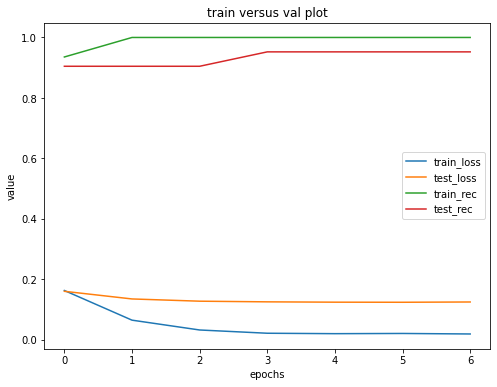

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(a1,label='train_loss')
plt.plot(b1,label='test_loss')
plt.plot(c1,label='train_rec')
plt.plot(d1,label='test_rec')


plt.xlabel("epochs")
plt.ylabel("value")
plt.title("train versus val plot")

plt.legend()
plt.show()

In [0]:
#torch.save(model_trained1.state_dict(), '/content/gdrive/My Drive/corona/ct_dataset/ct_scan/resnet50_lessdata_adam_tuneprevious_morelayertrain.h5')


In [0]:
model1 = models.resnet50(pretrained=False).to(device)
model1.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)
model1.load_state_dict(torch.load('/content/gdrive/My Drive/corona/ct_dataset/ct_scan/resnet50_adam_finetuning.h5'))

<All keys matched successfully>

In [0]:
modelxyz=model1 = models.resnet50(pretrained=False).to(device)
modelxyz.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)
modelxyz.load_state_dict(torch.load('/content/gdrive/My Drive/corona/ct_dataset/ct_scan/resnet50_lessdata_adam_tuneprevious_morelayertrain.h5'))

Now to save my final and the best performing model.This model can now perform well.

In [0]:
torch.save(modelxyz,'/content/gdrive/My Drive/corona/ct_dataset/ct_scan/best_model1.pth')


I would use the below code to keep my notebook running in between my short breaks.

In [0]:
import time
while 1:
  time.sleep(300)